### License

```
Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Dynamic World Model Runner

This notebook will step through the process of using the [Earth Engine API](https://developers.google.com/earth-engine) to generate an image of Dynamic World estimated probabilities from a Sentinel-2 L1C image, and then reverse the
probabilities back to reflectance.

This notebook was designed for [Google Colab](https://colab.research.google.com). Make sure to load any model files you intend to use in the Colab file dialog.

## Fetch a Sentinel-2 L1C image

Import the Earth Engine client library.

In [1]:
import ee

Authenticate with Earth Engine first; note this requires an [Earth Engine account](https://signup.earthengine.google.com). If you already have one, make sure to use the same Google account with which you signed up for Earth Engine.

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Sample a Sentinel-2 L1C image into a 3D array (height, width, bands).

In [3]:
import geopandas as gpd

# In this example, we'll define a point in the DRC.
POI = ee.Geometry.Point([91.820989,23.528797])

RESERVOIR = '0505'
ROI = gpd.read_file('../data/validation-locations/subset-validation-reservoirs-grand.geojson')
ROI = ROI[ROI['tmsos_id'] == RESERVOIR]
ROI.head(2)

GRAND_ID_left RES_NAME_left DAM_NAME_left ALT_NAME_left RIVER_left  \
82           5121          None         Gumti          None      Gumti   

   ALT_RIVER_left     MAIN_BASIN_left SUB_BASIN_left NEAR_CITY_left  \
82           None  Brahmaputra-Meghna           None        Amarpur   

   ALT_CITY_left  ...        db  name rid_id grand_id  rid_filepath  \
82          None  ...  deltares  None    NaN      NaN          None   

    resops_id  rid_filename  tmsos_id  distance  \
82        NaN          None      0505       NaN   

                                             geometry  
82  POLYGON ((91.82116 23.54628, 91.82196 23.54597...  

[1 rows x 129 columns]

## Replicate using data from GEE

In [4]:
import geemap

fc = geemap.gdf_to_ee(ROI)
fc

In [5]:
# This is Sentinel-2 L1C.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Filter the collection to mid-October 2021 intersecting the Point Of Interest.
s2 = s2.filterBounds(POI).filterDate('2019-01-01', '2019-01-10')

# Grab the first image in the filtered collection. Dynamic World uses a subset
# of Sentinel-2 bands, so we'll want to select down to just those.
s2_image = s2.first()
s2_image = s2_image.select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12')

# Resample the data so that the bands all map 1 pixel -> 10m. We'll use B2 (red)
# for a reference projection.
s2_image = s2_image.toFloat().resample('bilinear').reproject(
    s2_image.select('B2').projection());

# Squash the image bands down into an array-per-pixel, and sample out a square
# from our image centered on the POI. In this example, we'll go out 2km in each
# direction.
#
# This creates an ee.Feature with a property named "array" that we'll grab
# later.
s2_image_sample = s2_image.toArray().sampleRectangle(POI.buffer(2500))
s2_image_sample

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/eerepr/repr.py:85: UserWarning: HTML repr size (181mB) exceeds maximum (100mB), falling back to string repr. You can set `eerepr.options.max_repr_mbs` to print larger objects, but this may cause performance issues.
  warn(


Import Numpy.

In [6]:
import numpy as np

Get a Numpy array from our 3D array.

In [7]:
# image = s2_image
image = np.array(s2_image_sample.getInfo()['properties']['array'])[::3, ::3, :]

# Note this shape isn't exactly 400 a side (2 * 2km of 10m pixels) since the
# "buffer" we used earlier was in a different (geographic) projection than the
# pixels.
print(image.shape)


(167, 167, 9)


shape: (400, 399, 9); (X, Y, Band); Band order: 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'; blue, red, green, red-edge-5, red-edge-6, red-edge-7, NIR, SWIR11, SWIR12

In [8]:
image

array([[[ 312.    ,  535.    ,  597.    , ..., 1363.    ,  720.    ,
          406.875 ],
        [ 199.    ,  394.    ,  239.    , ..., 2315.    , 1184.625 ,
          536.25  ],
        [ 237.    ,  369.    ,  295.    , ..., 2146.    , 1368.0625,
          636.375 ],
        ...,
        [ 158.    ,  215.    ,  163.    , ..., 1177.    ,  923.    ,
          420.125 ],
        [ 158.    ,  212.    ,  160.    , ...,  942.    ,  975.6875,
          429.6875],
        [ 209.    ,  344.    ,  249.    , ..., 1887.    , 1334.75  ,
          629.9375]],

       [[ 275.    ,  432.    ,  418.    , ...,  961.    , 1015.125 ,
          511.125 ],
        [ 192.    ,  354.    ,  248.    , ..., 2593.    , 1190.625 ,
          542.0625],
        [ 223.    ,  418.    ,  349.    , ..., 2197.    , 1522.9375,
          724.125 ],
        ...,
        [ 204.    ,  416.    ,  272.    , ..., 2231.    , 1473.6875,
          652.25  ],
        [ 280.    ,  518.    ,  373.    , ..., 2499.    , 1687.8125,
   

### Normalize the image

In [9]:
original_image = image

# Define per-band constants we'll use to squash the Sentinel-2 reflectance range
# into something on (0, 1). These constants are 30/70 percentiles measured
# across a diverse set of surface conditions after a log transform.

NORM_PERCENTILES = np.array([
    [1.7417268007636313, 2.023298706048351],
    [1.7261204997060209, 2.038905204308012],
    [1.6798346251414997, 2.179592821212937],
    [1.7734969472909623, 2.2890068333026603],
    [2.289154079164943, 2.6171674549378166],
    [2.382939712192371, 2.773418590375327],
    [2.3828939530384052, 2.7578332604178284],
    [2.1952484264967844, 2.789092484314204],
    [1.554812948247501, 2.4140534947492487]])

image = np.log(image * 0.005 + 1)
image = (image - NORM_PERCENTILES[:, 0]) / NORM_PERCENTILES[:, 1]

# Get a sigmoid transfer of the re-scaled reflectance values.
image = np.exp(image * 5 - 1)
image = image / (image + 1)
res = image
sat_image = image

In [10]:
res

array([[[0.04828159, 0.11494815, 0.15683056, ..., 0.16902081,
         0.09978109, 0.12771806],
        [0.02666314, 0.07152592, 0.04521554, ..., 0.32515246,
         0.18743181, 0.17930937],
        [0.03316163, 0.0648319 , 0.05871061, ..., 0.29811128,
         0.22378346, 0.22150116],
        ...,
        [0.0205245 , 0.03098196, 0.02970953, ..., 0.13915908,
         0.13678875, 0.13278529],
        [0.0205245 , 0.03045225, 0.02916563, ..., 0.10325639,
         0.14678689, 0.13647772],
        [0.02829749, 0.05846335, 0.0474993 , ..., 0.25570705,
         0.21716785, 0.21875383]],

       [[0.04044277, 0.08230634, 0.09401915, ..., 0.1060595 ,
         0.15435043, 0.16896941],
        [0.0255512 , 0.06097126, 0.04726843, ..., 0.3681621 ,
         0.18861523, 0.18171872],
        [0.03067646, 0.07825115, 0.07329743, ..., 0.30633351,
         0.25447262, 0.25916845],
        ...,
        [0.02747356, 0.07767972, 0.05296142, ..., 0.31178638,
         0.24473561, 0.22828945],
        [0.0

View the effects of normalization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


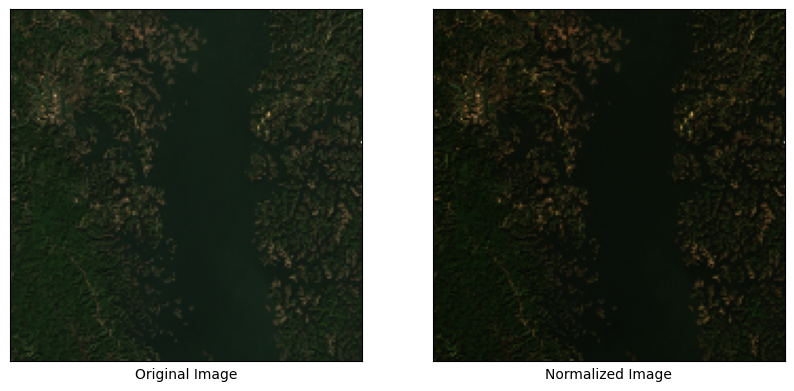

In [11]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

# Note we have to divide down the reflectance in the *original image* to be on 
# [0, 1] to display it with matplotlib; by convention we divide the RGB channels
# by 3000. 
axarr[0].imshow(original_image[:, :, [2, 1, 0]] / 3000)
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Original Image')

axarr[1].imshow(res[:, :, [2, 1, 0]])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel('Normalized Image')

plt.show()

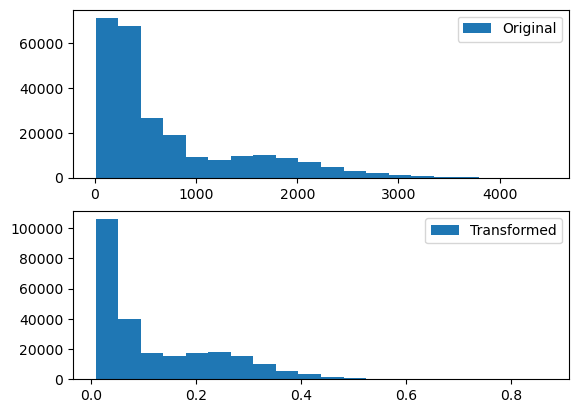

In [12]:
f, ax = plt.subplots(nrows=2)

ax[0].hist(original_image.ravel(), label='Original', bins=20)
ax[0].legend()
ax[1].hist(res.ravel(), label='Transformed', bins=20)
ax[1].legend()

## Obtain image from local instead of GEE

In [13]:
import xarray as xr
import rioxarray

im_fp = "../data/hls-all-bands/0505/*.nc"

ds = xr.open_mfdataset(im_fp, decode_coords='all', parallel=True)
ds.rio.set_spatial_dims('y', 'x', inplace=True)
bands = [
    'blue', 'green', 'red', 'red-edge 1', 'red-edge 2', 'red-edge 3', 'nir broad', 'swir 1', 'swir 2'
]
ds = ds[bands]
ds

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 205, y: 779, x: 650)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    spatial_ref         int32 4B 32646
    platform            (time) object 2kB dask.array<chunksize=(205,), meta=np.ndarray>
    eo:cloud_cover_avg  (time) float64 2kB dask.array<chunksize=(205,), meta=np.ndarray>
    reservoir           <U4 16B '0505'
Data variables:
    blue                (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    green               (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red                 (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 1          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 2          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 3          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    nir broad           (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    swir 1              (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    swir 2              (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>

Text(0.5, 1.0, 'HLS Data downloaded for selected reservoirs')

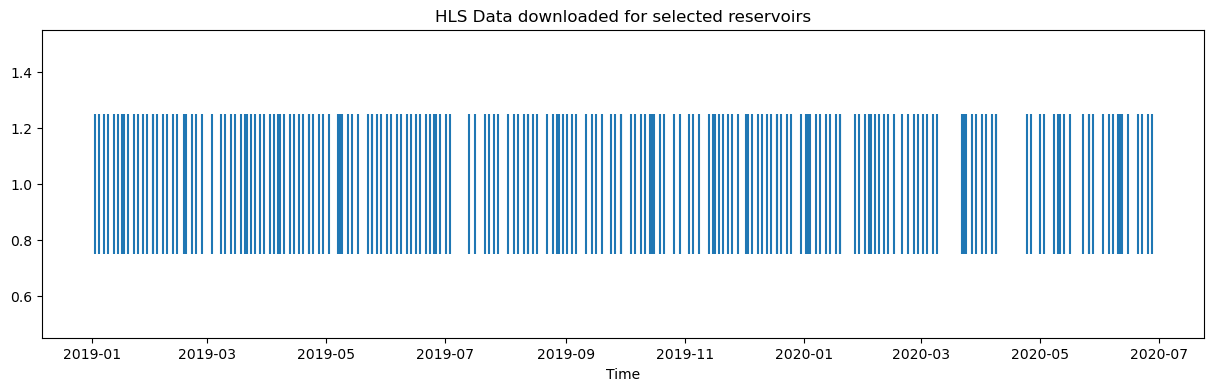

In [14]:
import numpy as np
fig, ax = plt.subplots(figsize=(15, 4))

yticks = []
ytick_labels = []
data = ds.time.values
name = 'Dumboor'
ax.eventplot(data, orientation='horizontal', linelengths=0.5)

ax.set_xlabel('Time')
ax.set_title('HLS Data downloaded for selected reservoirs')

In [15]:
import geemap
# Clip using reservoir extent + 10000m buffer
tgt_roi = ROI.to_crs(ds.rio.crs).buffer(10000)
ds = ds.rio.clip(tgt_roi.geometry.values)
ds

# # # Clip using the Point of Interest + 2500m buffer.
# # tgt_roi = geemap.ee_to_gdf(
# #     ee.FeatureCollection(ee.Feature(POI.buffer(2500)))
# # )

# print(tgt_roi.total_bounds)
# minx, miny, maxx, maxy = tgt_roi.total_bounds
# orig_crs = ds.rio.crs
# ds = ds.rio.reproject('epsg:4326')
# ds = ds.rio.clip_box(minx, miny, maxx, maxy)
# ds = ds.rio.reproject(orig_crs)
# ds

<xarray.Dataset> Size: 4GB
Dimensions:             (y: 779, x: 650, time: 205)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    platform            (time) object 2kB dask.array<chunksize=(205,), meta=np.ndarray>
    eo:cloud_cover_avg  (time) float64 2kB dask.array<chunksize=(205,), meta=np.ndarray>
    reservoir           <U4 16B '0505'
    spatial_ref         int64 8B 0
Data variables:
    blue                (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    green               (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red                 (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 1          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 2          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 3          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    nir broad           (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    swir 1              (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    swir 2              (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>

Image on 2019-01-04T04:31:57.140000000:  (779, 650)
Shape of initialized input array:  (779, 650, 9)
[[1.7417268  2.02329871]
 [1.7261205  2.0389052 ]
 [1.67983463 2.17959282]
 [1.77349695 2.28900683]
 [2.28915408 2.61716745]
 [2.38293971 2.77341859]
 [2.38289395 2.75783326]
 [2.19524843 2.78909248]
 [1.55481295 2.41405349]]


/tmp/ipykernel_4182692/1870975646.py:24: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)


(array([1.12841e+05, 2.77027e+05, 2.86300e+04, 3.45100e+03, 3.86000e+02,
        4.80000e+01, 1.50000e+01, 5.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([0.01193111, 0.0661788 , 0.1204265 , 0.17467419, 0.22892188,
        0.28316958, 0.33741727, 0.39166497, 0.44591266, 0.50016035,
        0.55440805]),
 <BarContainer object of 10 artists>)

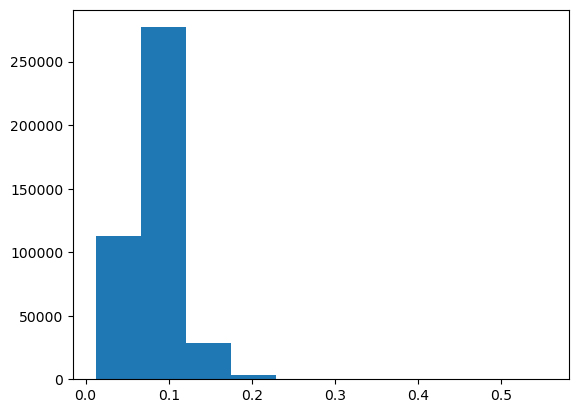

In [16]:
import numpy as np
import matplotlib.pyplot as plt

im_idx = 1
im = ds.isel(time=im_idx)
t = ds.time.values[im_idx]

print(f"Image on {t}: ", im['red'].shape)
res = np.zeros((im['red'].shape[0], im['red'].shape[1], 9)) # input array to DL model
print(f"Shape of initialized input array: ", res.shape)

res[:, :, 0] = im['blue'].data
res[:, :, 1] = im['green'].data
res[:, :, 2] = im['red'].data
res[:, :, 3] = im['red-edge 1'].data
res[:, :, 4] = im['red-edge 2'].data
res[:, :, 5] = im['red-edge 3'].data
res[:, :, 6] = im['nir broad'].data
res[:, :, 7] = im['swir 1'].data
res[:, :, 8] = im['swir 2'].data

original_res = res

res = np.log(res * 0.005 + 1)
# print(res)
NORM_PERCENTILES = np.array([
    [1.7417268007636313, 2.023298706048351],
    [1.7261204997060209, 2.038905204308012],
    [1.6798346251414997, 2.179592821212937],
    [1.7734969472909623, 2.2890068333026603],
    [2.289154079164943, 2.6171674549378166],
    [2.382939712192371, 2.773418590375327],
    [2.3828939530384052, 2.7578332604178284],
    [2.1952484264967844, 2.789092484314204],
    [1.554812948247501, 2.4140534947492487]])
res = (res - NORM_PERCENTILES[:, 0]) / (NORM_PERCENTILES[:, 1])
print(NORM_PERCENTILES)
# Get a sigmoid transfer of the re-scaled reflectance values.
res = np.exp(res * 5 - 1)
res = res / (res + 1)
plt.hist(res[:, :, 1].ravel())

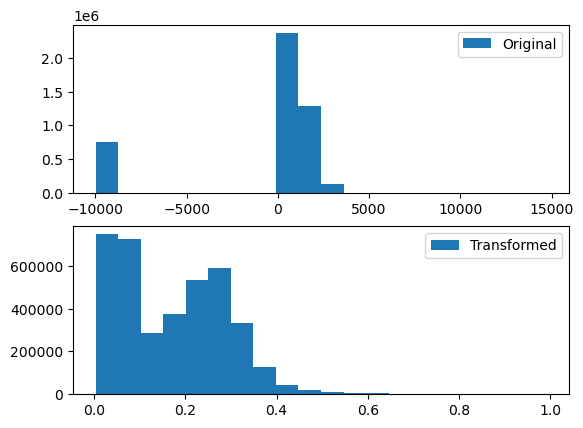

In [17]:
f, ax = plt.subplots(nrows=2)

ax[0].hist(original_res.ravel(), label='Original', bins=20)
ax[0].legend()
ax[1].hist(res.ravel(), label='Transformed', bins=20)
ax[1].legend()

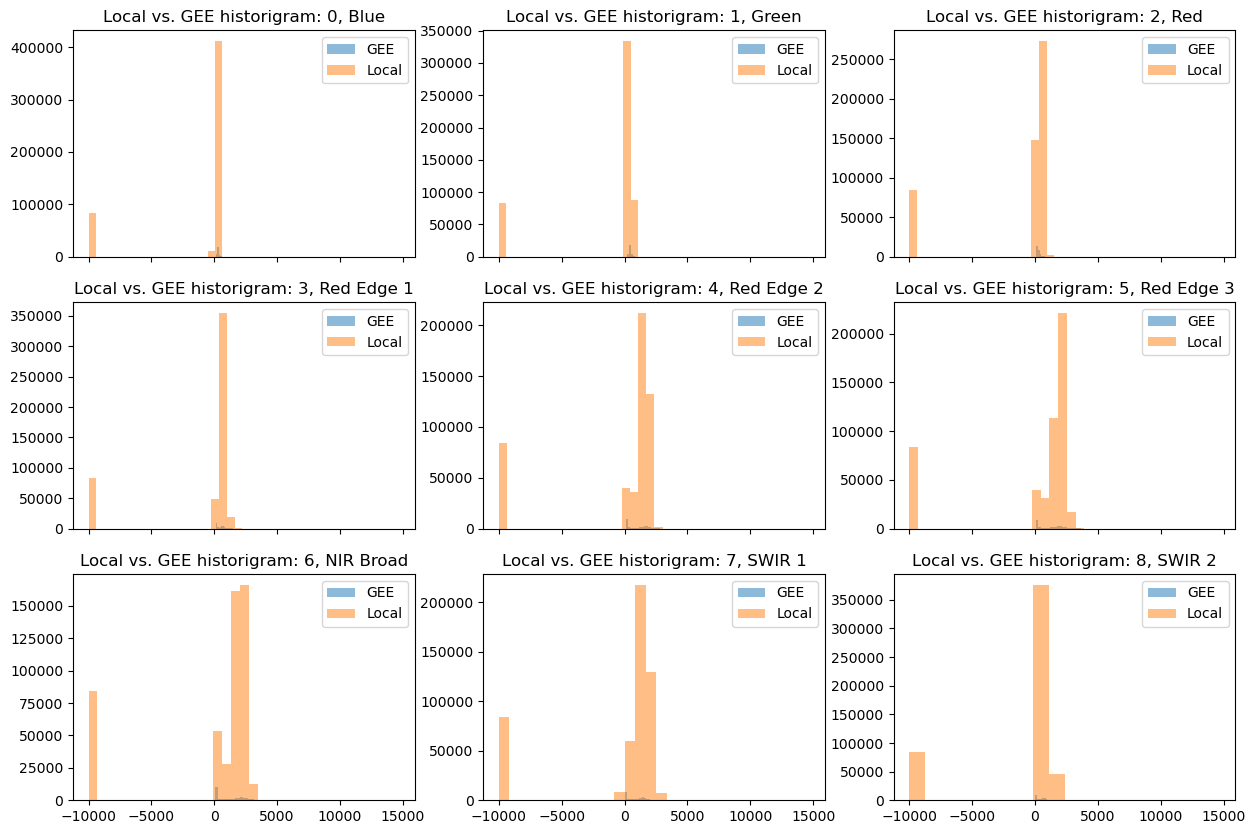

In [18]:
f, ax = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(15, 10))

band_names = {
    0: 'Blue',
    1: 'Green',
    2: 'Red',
    3: 'Red Edge 1',
    4: 'Red Edge 2',
    5: 'Red Edge 3',
    6: 'NIR Broad',
    7: 'SWIR 1',
    8: 'SWIR 2'
}

axes_flat = ax.flatten()
for band, ax in enumerate(axes_flat):
    ax.hist(original_image[:, :, band].ravel(), label='GEE', bins=20, alpha=0.5)
    ax.hist(original_res[:, :, band].ravel(), label='Local', bins=20, alpha=0.5)
    ax.legend()
    ax.set_title(f"Local vs. GEE historigram: {band}, {band_names[band]}")

<Axes: >

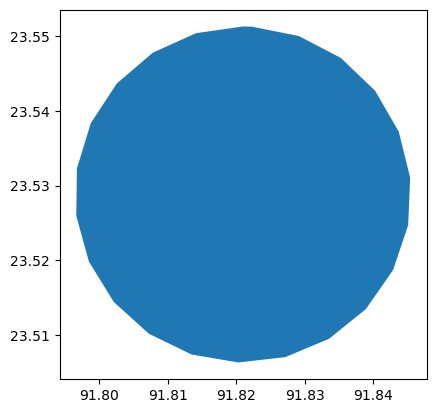

In [19]:
buffered_poi = geemap.ee_to_gdf(ee.Feature(POI.buffer(2500)))

buffered_poi.plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


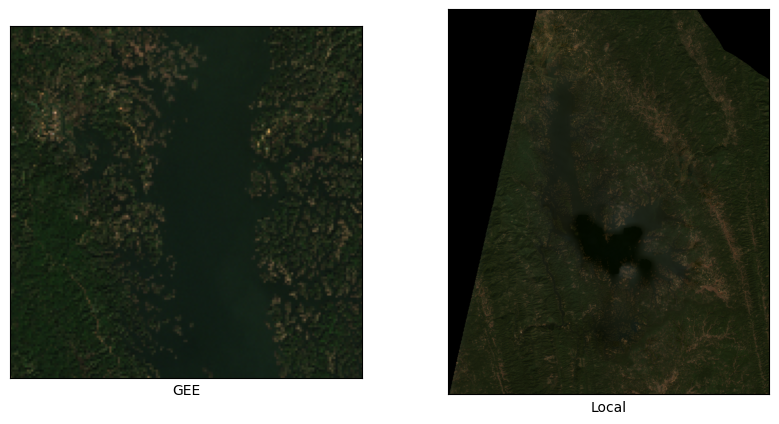

In [20]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

# Note we have to divide down the reflectance in the *original image* to be on 
# [0, 1] to display it with matplotlib; by convention we divide the RGB channels
# by 3000. 
axarr[0].imshow(original_image[:, :, [2, 1, 0]]/3000)
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('GEE')

axarr[1].imshow(original_res[:, :, [2, 1, 0]]/3000)
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel('Local')

plt.show()

## Load the forward model and make predictions

**For this to work properly, make sure you have uploaded the forward model into your Colab session at `/content/forward`.**

Import TensorFlow.

In [21]:
import tensorflow as tf

2024-05-26 17:23:35.017067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 17:23:35.078679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the forward model.

In [22]:
forward_model = tf.saved_model.load('../models/dw-forward')

Run the model on the normalized Sentinel-2 L1C image.

In [23]:
# DynamicWorld expects 4D (NHWC), float32 typed inputs.
nhwc_image = tf.expand_dims(tf.cast(res, dtype=tf.float32), axis=0)

# Run the model.
lulc_logits = forward_model(nhwc_image)

# Get the softmax of the output logits.
lulc_prob = tf.nn.softmax(lulc_logits)

# Convert the 4D probabilites back into a 3D numpy array for easier indexing.
lulc_prob = np.array(lulc_prob[0])

Visualize the estimated LULC probabilities.

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


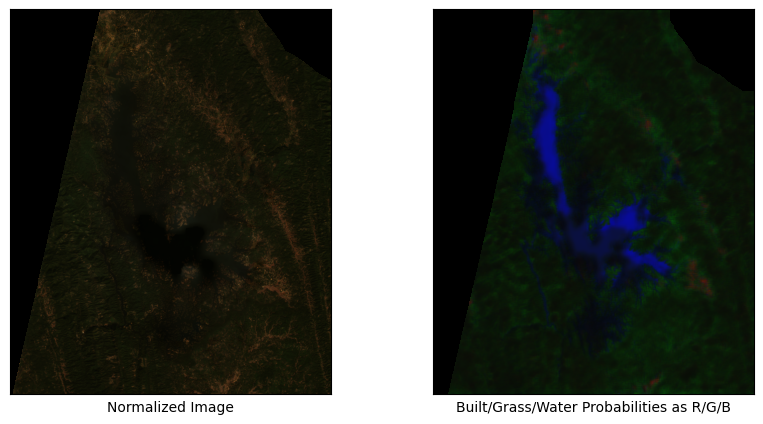

In [24]:
f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

axarr[0].imshow(res[:, :, [2, 1, 0]])
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Normalized Image')

# Note 6, 2, and 0 map to DynamicWorld Built, Grass, and Water classes.
axarr[1].imshow(lulc_prob[:, :, [6, 2, 0]])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel(
    'Built/Grass/Water Probabilities as R/G/B')

plt.show()

(array([22544., 14292.,  9830.,  5974.,  4366.,  3510.,  2805.,  2301.,
         1968.,  1654.,  1425.,  1259.,  1270.,  1396.,  1861.,   846.,
          618.,   591.,   502.,   461.,   478.,   457.,   452.,   439.,
          462.,   511.,   535.,   601.,   650.,   648.,   647.,   594.,
          550.,   559.,   615.,   635.,  1201.,   595.,   287.,   166.]),
 array([0.05000028, 0.06381263, 0.07762498, 0.09143732, 0.10524968,
        0.11906203, 0.13287438, 0.14668673, 0.16049908, 0.17431143,
        0.18812378, 0.20193613, 0.21574849, 0.22956084, 0.24337319,
        0.25718555, 0.27099788, 0.28481025, 0.29862258, 0.31243494,
        0.32624727, 0.34005964, 0.353872  , 0.36768433, 0.3814967 ,
        0.39530903, 0.40912139, 0.42293373, 0.43674609, 0.45055845,
        0.46437079, 0.47818315, 0.49199548, 0.50580782, 0.51962018,
        0.53343254, 0.54724491, 0.56105727, 0.57486957, 0.58868194,
        0.6024943 ]),
 <BarContainer object of 40 artists>)

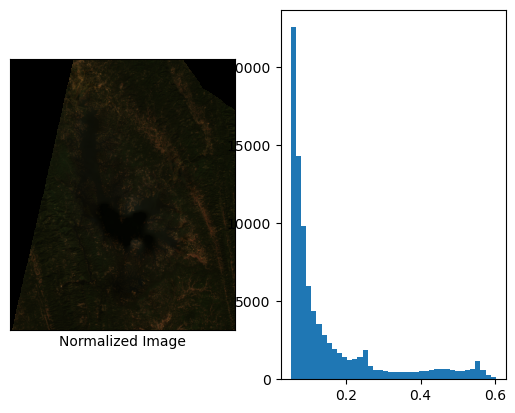

In [25]:
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(res[:, :, [2, 1, 0]])
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Normalized Image')

# Note 6, 2, and 0 map to DynamicWorld Built, Grass, and Water classes.
# mpl_im = axarr[1].imshow(np.argmax(lulc_prob, axis=2), cmap='Set1')
# mpl_im = axarr[1].imshow(lulc_prob[:, :, 0] > 0.1, cmap='Blues')
# axarr[1].axes.get_xaxis().set_ticks([])
# axarr[1].axes.get_yaxis().set_ticks([])
# axarr[1].axes.set_xlabel('Water map')
# axarr[0].set_title("RGB")
# axarr[1].set_title("Water Map")
# f.suptitle("Water classified using Google Dynamic World (Local Data)\nwater = > 0.15 probability by Dynamic World")
# cbar = plt.colorbar(mpl_im)
# plt.tight_layout()
# plt.show()
axarr[1].hist(np.where(lulc_prob[:, :, 0].ravel() > 0.05, lulc_prob[:, :, 0].ravel(), np.nan), bins=40)

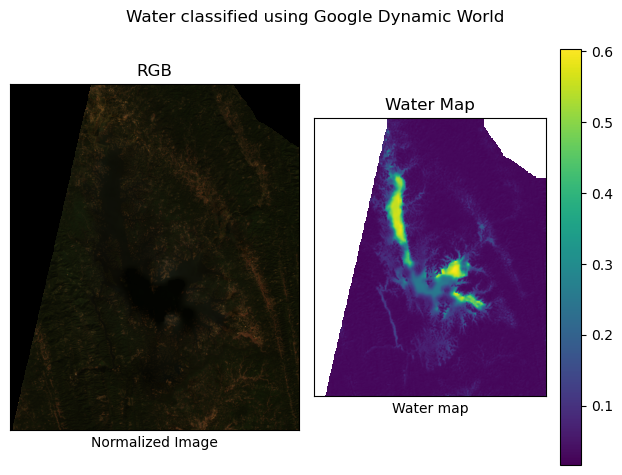

In [26]:
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(res[:, :, [2, 1, 0]])
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Normalized Image')

# Note 6, 2, and 0 map to DynamicWorld Built, Grass, and Water classes.
# mpl_im = axarr[1].imshow(np.argmax(lulc_prob, axis=2), cmap='Set1')
mpl_im = axarr[1].imshow(lulc_prob[:, :, 0])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel('Water map')
axarr[0].set_title("RGB")
axarr[1].set_title("Water Map")
f.suptitle("Water classified using Google Dynamic World")
cbar = plt.colorbar(mpl_im)
plt.tight_layout()
plt.show()

## generate a time series

In [27]:
def classify_dl(im):
    # im = ds.isel(time=im_idx)
    # t = ds.time.values[im_idx]
    res = np.zeros((im['red'].shape[0], im['red'].shape[1], 9)) # input array to DL model
    res[:, :, 0] = im['blue'].data
    res[:, :, 1] = im['green'].data
    res[:, :, 2] = im['red'].data
    res[:, :, 3] = im['red-edge 1'].data
    res[:, :, 4] = im['red-edge 2'].data
    res[:, :, 5] = im['red-edge 3'].data
    res[:, :, 6] = im['nir broad'].data
    res[:, :, 7] = im['swir 1'].data
    res[:, :, 8] = im['swir 2'].data

    res = np.log(res * 0.005 + 1)
    # print(res)
    NORM_PERCENTILES = np.array([
        [1.7417268007636313, 2.023298706048351],
        [1.7261204997060209, 2.038905204308012],
        [1.6798346251414997, 2.179592821212937],
        [1.7734969472909623, 2.2890068333026603],
        [2.289154079164943, 2.6171674549378166],
        [2.382939712192371, 2.773418590375327],
        [2.3828939530384052, 2.7578332604178284],
        [2.1952484264967844, 2.789092484314204],
        [1.554812948247501, 2.4140534947492487]])
    res = (res - NORM_PERCENTILES[:, 0]) / (NORM_PERCENTILES[:, 1])

    # Get a sigmoid transfer of the re-scaled reflectance values.
    res = np.exp(res * 5 - 1)
    res = res / (res + 1)

    # DynamicWorld expects 4D (NHWC), float32 typed inputs.
    nhwc_image = tf.expand_dims(tf.cast(res, dtype=tf.float32), axis=0)

    # Run the model.
    lulc_logits = forward_model(nhwc_image)

    # Get the softmax of the output logits.
    lulc_prob = tf.nn.softmax(lulc_logits)

    # Convert the 4D probabilites back into a 3D numpy array for easier indexing.
    lulc_prob = np.array(lulc_prob[0])
    lulc_prob_da = xr.DataArray(
        lulc_prob, dims=('y', 'x', 'lulc'), 
        coords={'lulc': ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']},
        name='lulc_prob'
    )
    normalized_input = xr.DataArray(
                data=res, 
                # dims=('y', 'x', 'band'),
                coords = (
                    ('y', im.y.values),
                    ('x', im.x.values),
                    ('band', ['blue', 'green', 'red', 'red-edge 1', 'red-edge 2', 'red-edge 3', 'nir broad', 'swir 1', 'swir 2'])
                ),
                name = 'normalized_input'
            )
    res_ds = xr.combine_by_coords([lulc_prob_da, normalized_input])
    res_ds.coords['spatial_ref'] = im.spatial_ref

    return res_ds

In [28]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)
client

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37623 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:38815' processes=8 threads=8, memory=187.55 GiB>

In [29]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:             (y: 779, x: 650, time: 205)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    platform            (time) object 2kB dask.array<chunksize=(205,), meta=np.ndarray>
    eo:cloud_cover_avg  (time) float64 2kB dask.array<chunksize=(205,), meta=np.ndarray>
    reservoir           <U4 16B '0505'
    spatial_ref         int64 8B 0
Data variables:
    blue                (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    green               (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red                 (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 1          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 2          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    red-edge 3          (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    nir broad           (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    swir 1              (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>
    swir 2              (time, y, x) float32 415MB dask.array<chunksize=(205, 779, 650), meta=np.ndarray>

In [30]:
ds = ds.load()
ds

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 3.67 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset> Size: 4GB
Dimensions:             (y: 779, x: 650, time: 205)
Coordinates:
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    platform            (time) object 2kB 'Sentinel-2A' ... 'Landsat-8'
    eo:cloud_cover_avg  (time) float64 2kB 0.0 0.0 0.0 0.0 ... 72.0 73.0 100.0
    reservoir           <U4 16B '0505'
    spatial_ref         int64 8B 0
Data variables:
    blue                (time, y, x) float32 415MB 181.0 185.0 ... -9.999e+03
    green               (time, y, x) float32 415MB 374.0 365.0 ... -9.999e+03
    red                 (time, y, x) float32 415MB 237.0 224.0 ... -9.999e+03
    red-edge 1          (time, y, x) float32 415MB 621.0 620.0 ... -9.999e+03
    red-edge 2          (time, y, x) float32 415MB 1.859e+03 ... -9.999e+03
    red-edge 3          (time, y, x) float32 415MB 2.307e+03 ... -9.999e+03
    nir broad           (time, y, x) float32 415MB 2.433e+03 ... -9.999e+03
    swir 1              (time, y, x) float32 415MB 1.5e+03 ... -9.999e+03
    swir 2              (time, y, x) float32 415MB 637.0 573.0 ... -9.999e+03

In [31]:
classified = ds.groupby('time').apply(classify_dl)
classified

/tmp/ipykernel_4182692/86516340.py:1: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  classified = ds.groupby('time').apply(classify_dl)
/tmp/ipykernel_4182692/3322836701.py:15: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)
/tmp/ipykernel_4182692/3322836701.py:15: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)
/tmp/ipykernel_4182692/3322836701.py:15: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)
/tmp/ipykernel_4182692/3322836701.py:15: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)
/tmp/ipykernel_4182692/3322836701.py:15: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)
/tmp/ipykernel_4182692/3322836701.py:15: RuntimeWarning: invalid value encountered in log
  res = np.log(res * 0.005 + 1)
/tmp/

<xarray.Dataset> Size: 11GB
Dimensions:             (time: 205, y: 779, x: 650, lulc: 9, band: 9)
Coordinates:
  * lulc                (lulc) <U18 648B 'water' 'trees' ... 'snow_and_ice'
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * band                (band) <U10 360B 'blue' 'green' ... 'swir 1' 'swir 2'
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    platform            (time) object 2kB 'Sentinel-2A' ... 'Landsat-8'
    eo:cloud_cover_avg  (time) float64 2kB 0.0 0.0 0.0 0.0 ... 72.0 73.0 100.0
    reservoir           <U4 16B '0505'
    spatial_ref         int64 8B 0
Data variables:
    lulc_prob           (time, y, x, lulc) float32 4GB 0.03525 0.5677 ... nan
    normalized_input    (time, y, x, band) float64 7GB 0.02386 0.06614 ... nan

In [32]:
import hvplot.xarray
import geoviews as gv

(
    (classified['lulc_prob'].sel(lulc='water') > 0.15).sum(dim=('x', 'y')) * 30*30 * 1e-6).hvplot(
        x='time', kind='scatter'
)

:Scatter   [time]   (lulc_prob)

In [33]:
(classified['lulc_prob'].sel(lulc='water')).hvplot.image(
    x='x', y='y', color='lulc', groupby='time', cmap='RdBu', clim=(0, 0.2)
).opts(aspect='equal', width=600, height=500)

BokehModel(combine_events=True, render_bundle={'docs_json': {'bde8a719-f110-40f7-9e27-45c4b2ccecdd': {'version…

### apply pekel cloud correction

In [34]:
from pathlib import Path
import geopandas as gpd
import hvplot.pandas
import geoviews as gv

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

val_res_pt = val_pts
val_res_poly = val_polys

val_res_pt.hvplot(geo=True, tiles='OSM') * val_res_pt[val_res_pt['tmsos_id'] == RESERVOIR].hvplot(geo=True, color='red', size=100)

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

In [35]:
from pathlib import Path
from rasterio.crs import CRS


# code for cloud cover correction
pekel_dir = Path('../data/pekel/occurrence_nc')

def get_pekel_for_reservoir(reservoir_id):
    res_poly = val_res_poly[val_res_poly['tmsos_id']==reservoir_id]
    roi = res_poly.copy()
    pekel_ds = get_pekel_dataset(roi)

    pekel_ds = pekel_ds.assign_coords({
        'reservoir': [reservoir_id]
    })

    return pekel_ds

def get_pekel_dataset(roi, scaling_factor=1.05):
    print(f"ROI CRS: ", roi.crs)
    roi_4326 = roi.to_crs('epsg:4326')
    
    fnx_l = int(roi_4326.total_bounds[0].round(-1)-10)
    fny_l = int(roi_4326.total_bounds[1].round(-1))
    fnx_u = int(roi_4326.total_bounds[2].round(-1))
    fny_u = int(roi_4326.total_bounds[3].round(-1)+10)
    tiles = [
        f"{abs(dx)}{'E' if dx >=0 else 'W'}_{abs(dy)}{'N' if dy >= 0 else 'S'}" for dx in range(fnx_l, fnx_u+1, 10) for dy in range(fny_l, fny_u+1, 10)]
    print("roi (epsg:4326) total bounds: ", roi_4326.total_bounds)
    print("tile limits: ", fnx_l, fny_l, fnx_u, fny_u)
    print("tiles: ", tiles)
    
    fns = [pekel_dir / f"occurrence_{tile}v1_4_2021.nc" for tile in tiles]
    ds = xr.open_mfdataset(fns, chunks={'x': 1024*5, 'y': 1024*5}, decode_coords="all").sel(band=1)
        
    ds['band_data'] = ds['band_data'].rio.write_nodata(-1)
    ds = ds.rename({'band_data': 'occurrence'})
    
    ds = ds.rio.set_crs('epsg:4326')
    ds = ds.rio.clip_box(*roi_4326.total_bounds)
    
    ds['occurrence'] = (ds['occurrence'] * scaling_factor).clip(0, 100)

    return ds

def get_occurrence_like(roi, reproject_match, stretching_factor=1.05):
    """Get occurence over ROI. Always converts to estimated UTM projection.

    Inputs
    ------
    roi (geopandas.GeoDataFrame): ROI in WGS84.
    reproject_match (xarray.Dataset): Dataset to reproject to.
    stretching_factor (float): Factor to stretch the occurrence values by. Default is 1.05. 
        Multiples occurernce by this factor and clips to 0-100. This is to minimize the effect of 
        underestimation of occurrence which can happen in Pekel dataset since it is based on Landsat 
        optical data.
    """
    pekel_ds = get_pekel_dataset(roi, stretching_factor)
    crs_wkt = reproject_match.spatial_ref.attrs['crs_wkt']
    # histogram to find threshold of occurrence
    occurrence = pekel_ds['occurrence'].rio.reproject_match(reproject_match).transpose('y', 'x')
    occurrence.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    occurrence.rio.write_crs(CRS.from_wkt(crs_wkt), inplace=True)
    occurrence.rio.write_nodata(np.nan, inplace=True)
    occurrence = occurrence.rio.clip(roi.to_crs(crs_wkt).geometry.values, drop=True)
    return occurrence

In [36]:
import dask

In [37]:
RESERVOIR = '0505'

res_poly = val_res_poly[val_res_poly['tmsos_id']==RESERVOIR]
water_map_ds = classified['lulc_prob'].sel(lulc='water').isel(time=-1)

roi = res_poly.copy()

roi['geometry'] = roi['geometry'].to_crs(
    CRS.from_wkt(water_map_ds.spatial_ref.attrs['crs_wkt'])
).buffer(2_000) # buffer 2 km
roi.crs = CRS.from_wkt(water_map_ds.spatial_ref.attrs['crs_wkt'])



with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    occurrence = get_occurrence_like(roi, reproject_match=water_map_ds, stretching_factor=1.1)

occurrence

ROI CRS:  PROJCS["WGS 84 / UTM zone 46N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32646"]]
roi (epsg:4326) total bounds:  [91.78915544 23.42112008 91.91714662 23.56680602]
tile limits:  80 20 90 30
tiles:  ['80E_20N', '80E_30N', '90E_20N', '90E_30N']


<xarray.DataArray 'occurrence' (y: 539, x: 435)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB 3.764e+05 3.764e+05 ... 3.894e+05 3.894e+05
  * y            (y) float64 4kB 2.607e+06 2.607e+06 ... 2.591e+06 2.591e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [38]:
perm_water_hv = (
    xr.where(occurrence >= 97, 1, np.nan)
).hvplot.image(
    x='x', y='y', geo=True, cmap='Blues', label='permanent water'
)

transitional_water_hv = (
    xr.where((occurrence < 97) & (occurrence > 0), 1, np.nan)
).hvplot.image(
    x='x', y='y', geo=True, cmap='RdYlGn', label='transitional water'
)

(perm_water_hv * transitional_water_hv).opts(aspect='equal')

:Overlay
   .Image.Permanent_water    :Image   [x,y]   (occurrence)
   .Image.Transitional_water :Image   [x,y]   (occurrence)

In [39]:
from rasterio.crs import CRS
import numpy as np
import dask
import dask.array as da


def zhao_and_gao_dw(water_map, occurrence, omega=0.2):
    occurrence_orig = occurrence.rio.reproject_match(water_map.fillna(0))
  
    def zg(water_map_block):
        times = water_map_block.time
        res = xr.zeros_like(water_map_block)

        for i, time in enumerate(times):
            water_map_slice = water_map_block.sel(time=time)
            mask_slice = np.isnan(water_map_slice) * 1
            if mask_slice.sum()/np.ones_like(mask_slice).sum() < 0.99:
                occurrence_slice = xr.where(~mask_slice, occurrence_orig, np.nan)
                occurrence_slice = xr.where(water_map_slice==1, occurrence_slice, np.nan)
                occurrence_counts, occurrence_values = np.histogram(occurrence_slice.values, bins=99, range=(1, 100))
                count_threshold = np.nanmean(occurrence_counts) * omega
                occurrence_idx = np.nanargmax(np.where(occurrence_counts > count_threshold) if (occurrence_counts > count_threshold).sum() > 0 else [0])
                occurrence_idx = np.nan if occurrence_idx == 0 else occurrence_idx
                
                pekel_estimated_map = (occurrence_orig >= occurrence_idx)
        
                corrected_map = xr.where(
                    mask_slice,
                    pekel_estimated_map,
                    water_map_slice,
                )
                res.data[i] = corrected_map
            else:
                res.data[i] = np.full_like(water_map_slice, 2)
        
        return res
    
    # water_map = water_map.chunk({'time': 50, 'x': -1, 'y': -1})
    water_map = water_map.transpose('time', 'y', 'x')
    # res = water_map.groupby('time').apply(zg).rename("surface_water")
    res = water_map.map_blocks(
        zg, template=water_map
    ).rename("surface_water")
    res.rio.set_nodata(2)
    
    return res


water_map_ds = ((classified['lulc_prob'].sel(lulc='water') > 0.15) * 1).rename("surface_water")
water_map_ds = xr.where(~np.isnan(classified['lulc_prob'].sel(lulc='water')), water_map_ds, np.nan)
water_map_ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
water_map_ds.rio.write_crs(classified.rio.crs, inplace=True)
water_map_ds

corrected_water_map = zhao_and_gao_dw(water_map_ds, occurrence)
corrected_water_map

<xarray.DataArray 'surface_water' (time: 205, y: 779, x: 650)> Size: 830MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        ...,
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.]],

       [[2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        ...,
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.],
        [2., 2., 2., ..., 2., 2., 2.]]])
Coordinates:
    lulc                <U18 72B 'water'
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    platform            (time) object 2kB 'Sentinel-2A' ... 'Landsat-8'
    eo:cloud_cover_avg  (time) float64 2kB 0.0 0.0 0.0 0.0 ... 72.0 73.0 100.0
    reservoir           <U4 16B '0505'
    spatial_ref         int64 8B 0

In [40]:
((corrected_water_map == 1).sum(dim=('x', 'y')) * 30*30 * 1e-6).hvplot(x='time', kind='scatter')

:Scatter   [time]   (surface_water)

In [41]:
water_map_ds.sum(dim=['x', 'y']).rename('surface_water').hvplot(x='time', kind='scatter')

:Scatter   [time]   (surface_water)

In [42]:
rgb = ds.to_dataarray(
    dim = 'band'
).sel(band=['red', 'green', 'blue'])

rgb = (rgb - rgb.min(dim=['x', 'y'])) / (rgb.max(dim=['x', 'y']) - rgb.min(dim=['x', 'y']))
gamma = 0.12
gamma_corrected_rgb = rgb ** (1/gamma)

gamma_corrected_rgb_hv = gamma_corrected_rgb.hvplot.rgb(
    x='x', y='y', groupby='time', bands='band'
).opts(
    aspect='equal', width=500, height=350
)


In [43]:
# classified['lulc_prob'].isel(time=slice(0, 10)).sel(lulc='water').hvplot(x='x', y='y', groupby='time', geo=True, cmap="RdBu", clim=(0, 0.15))
(corrected_water_map.hvplot(
    x='x', y='y', groupby='time', cmap="RdBu", clim=(0, 0.15)
).opts(
    width=500, height=350, aspect='equal'
) + (classified['lulc_prob'].sel(lulc='water')).hvplot.image(
    x='x', y='y', color='lulc', groupby='time', cmap='RdBu', clim=(0, 0.2)
).opts(
    aspect='equal', width=500, height=350
) + gamma_corrected_rgb_hv).cols(2)

BokehModel(combine_events=True, render_bundle={'docs_json': {'b1cada1b-45b7-42ac-9df1-3b3e5d81fe08': {'version…

In [44]:
#### PLOT
rgb_ds = ds.to_dataarray(
    dim = 'band'
).sel(band=['red', 'green', 'blue'])

mask_ds = water_map_ds
mask_ds

<xarray.DataArray (time: 205, y: 779, x: 650)> Size: 830MB
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lulc                <U18 72B 'water'
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
    platform            (time) object 2kB 'Sentinel-2A' ... 'Landsat-8'
    eo:cloud_cover_avg  (time) float64 2kB 0.0 0.0 0.0 0.0 ... 72.0 73.0 100.0
    reservoir           <U4 16B '0505'
    spatial_ref         int64 8B 0

In [45]:
area = water_map_ds.sum(dim=('x', 'y')).rename('water area (km2)') * 30 * 30 * 1e-6
# area = area[area['eo:cloud_cover_avg']<20]
area.hvplot(kind='scatter', x='time', y='water area (km2)')

:Scatter   [time]   (water area (km2))

### Save results

In [46]:
area.to_pandas()

time
2019-01-02 04:41:48.360    20.9295
2019-01-04 04:31:57.140    23.9562
2019-01-07 04:41:52.710     3.0780
2019-01-09 04:31:54.330    22.7763
2019-01-12 04:41:49.830    26.9127
                            ...   
2020-06-15 04:42:00.352     0.0000
2020-06-20 04:41:56.768     0.4581
2020-06-22 04:32:04.846     0.0549
2020-06-25 04:42:13.945     0.0000
2020-06-27 04:18:23.486     0.0000
Length: 205, dtype: float64

In [56]:
df = area.rename('hls dw area [km2]').to_pandas().reset_index().rename({
    0: 'hls dw area [km2]'
}, axis=1)
df['reservoir'] = RESERVOIR
df.head()

time  hls dw area [km2] reservoir
0 2019-01-02 04:41:48.360            20.9295      0505
1 2019-01-04 04:31:57.140            23.9562      0505
2 2019-01-07 04:41:52.710             3.0780      0505
3 2019-01-09 04:31:54.330            22.7763      0505
4 2019-01-12 04:41:49.830            26.9127      0505

In [57]:
version = '0.1'
save_dir = Path(f'../data/area/hls_dw_cld/v{version}')
save_dir.mkdir(exist_ok=True, parents=True)

for key, df in df.groupby('reservoir'):
    save_fp = save_dir / f'{key}.csv'
    print(f'saving {save_fp}')
    df.to_csv(save_fp, index=False)

saving ../data/area/hls_dw_cld/v0.1/0505.csv


# Extra

## Load the backward model and synthesize reflectance

**For this to work properly, make sure you have uploaded the backward model into your Colab session at `/content/backward`.**

Load the backward model.

In [ ]:
backward_model = tf.saved_model.load('model/backward')

Draw a crop circle using PIL.

In [ ]:
#@title
import math
from PIL import Image, ImageDraw

X = 290
Y = 180
R = 35
ANGLE = 280
WIDTH = 8

crop_circle = Image.new('1', (lulc_prob.shape[1], lulc_prob.shape[0]))
canvas = ImageDraw.Draw(crop_circle)

canvas.arc((X - R, Y - R, X + R, Y + R),
           start=ANGLE + 135, end=ANGLE + 45, fill=1, width=WIDTH)
canvas.arc((X - R * 0.6, Y - R * 0.6, X + R * 0.6, Y + R * 0.6),
           start=ANGLE + 315, end=ANGLE + 225, fill=1, width=WIDTH)
canvas.ellipse((X - R * 0.2, Y - R * 0.2, X + R * 0.2, Y + R * 0.2), fill=1)

ANGLE_RADS = ANGLE * math.pi / 180
axis = np.array([math.cos(ANGLE_RADS), math.sin(ANGLE_RADS)])

coords = (X + axis[0] * -R, Y + axis[1] * -R,
          X + axis[0] * R * -1.286, Y + axis[1] * R * -1.286)
canvas.line(coords, fill=1, width=WIDTH)

coords = (X + axis[0] * R, Y + axis[1] * R,
          X + axis[0] * R * 1.286, Y + axis[1] * R * 1.286)
canvas.line(coords, fill=1, width=WIDTH)

SMALL_X, SMALL_Y = X + axis[0] * R * 1.8, Y + axis[1] * R * 1.8
canvas.arc((SMALL_X - R * 0.5, SMALL_Y - R * 0.5,
            SMALL_X + R * 0.5, SMALL_Y + R * 0.5),
           start=ANGLE + 315, end=ANGLE + 225, fill=1, width=WIDTH)
canvas.ellipse((SMALL_X - R * 0.15, SMALL_Y - R * 0.15,
                SMALL_X + R * 0.15, SMALL_Y + R * 0.15), fill=1)

coords = (SMALL_X + axis[0] * R * 0.5, SMALL_Y + axis[1] * R * 0.5,
          SMALL_X + axis[0] * R * 0.8, SMALL_Y + axis[1] * R * 0.8)
canvas.line(coords, fill=1, width=WIDTH)

aug_source = np.array(crop_circle)

Make the generated image modulate the crop probability with some noise.

In [ ]:
#@title
# Add a channel dimension to the augmentation.
augmentation = np.expand_dims(aug_source, axis=-1)
augmentation_mask = augmentation

# Create a one-hot encoded version of the augmentation image, and add some
# noise.
#
# Note channel 4 corresponds to crops.
aug_channels = augmentation * np.array([0, 0, 0, 0, 1, 0, 0, 0, 0],
                                       dtype=np.float32)
aug_channels += np.random.normal(scale=0.02, size=aug_channels.shape)
aug_channels /= np.sum(aug_channels, axis=2, keepdims=True)
aug_channels *= augmentation

Fold the generated image into the forward model's output's.

In [ ]:
lulc_prob_aug = (
    lulc_prob * (1 - augmentation_mask) + aug_channels * augmentation_mask)

Run the backwards model on the augmented probabilities.

In [ ]:
# DynamicWorld expects 4D (NHWC), float32 typed inputs.
nhwc_image = tf.expand_dims(tf.cast(lulc_prob, dtype=tf.float32), axis=0)
nhwc_image_aug = tf.expand_dims(tf.cast(lulc_prob_aug, dtype=tf.float32),
                                axis=0)

# Run the model twice: once for the raw probabilities and once for the raw
# probabilities plus our augmentation.
synthetic_s2 = backward_model(nhwc_image)
synthetic_s2_aug = backward_model(nhwc_image_aug)

# Convert the 4D probabilites back into a 3D numpy array for easier indexing.
synthetic_s2 = np.array(synthetic_s2[0])
synthetic_s2_aug = np.array(synthetic_s2_aug[0])

Visualize the synthesized Sentinel-2 L1C image.

In [ ]:
f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

axarr[0].imshow(synthetic_s2[:, :, [2, 1, 0]])
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Synthetic Image')

axarr[1].imshow(synthetic_s2_aug[:, :, [2, 1, 0]])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel('Synthetic Image + Augmentation')

plt.show()